This Notebook is for removing outliers from our dataset. Currently we remove businesses that have a low number of orders (below the 1% quantile.) We then generate some distribution plots and compare it to our plots from distribution_analysis.ipynb. 

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/09/29 20:54:00 WARN Utils: Your hostname, DulanComputer resolves to a loopback address: 127.0.1.1; using 172.30.15.25 instead (on interface eth0)
23/09/29 20:54:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/29 20:54:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df = df.withColumn('sales_volume', col('number_of_orders') * col('average_cost_of_order'))
df.show(5)
df.printSchema()
print("length:",df.count())
df_pandas = df.toPandas()



23/09/29 20:54:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+-------------+---------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+-------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+---------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|consumer_retainability|number_of_orders|avera

garden_and_furnishings


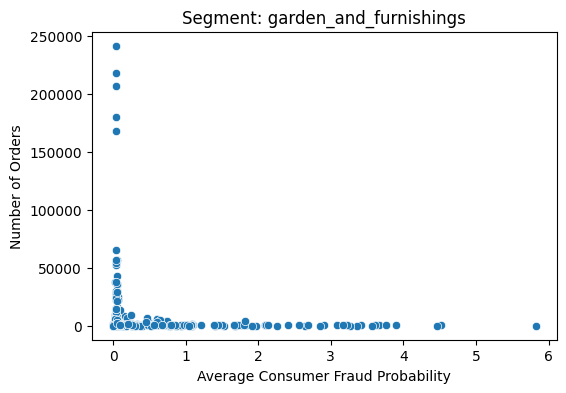

tech_and_electronics


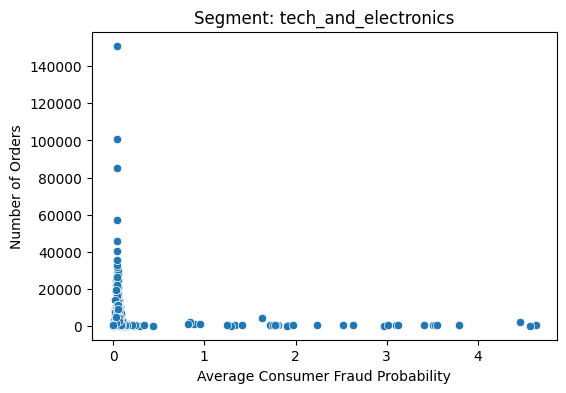

antiques_and_jewellery


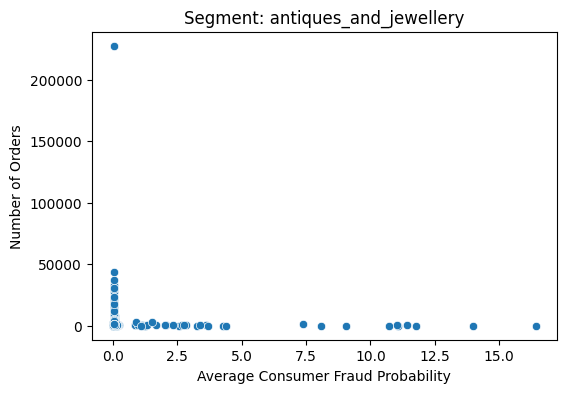

retail_and_novelty


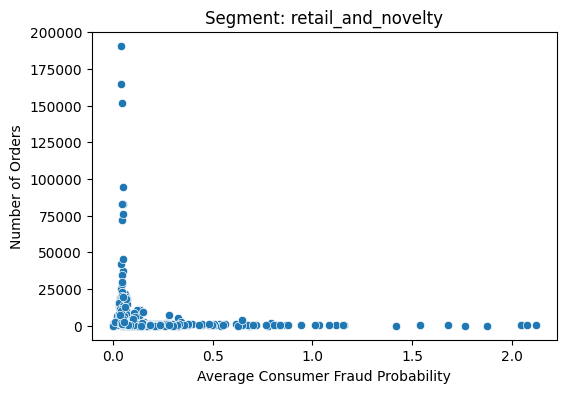

specialized_services


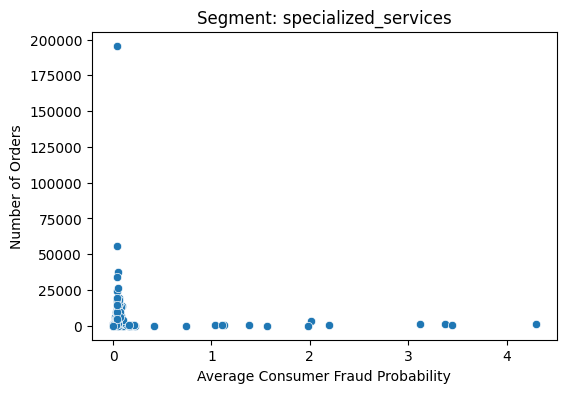

In [3]:
import pandas as pd
import seaborn as sns
# Initialize an empty list to hold the outliers

for segment in df_pandas['segment'].unique():
    # Filter the dataframe for each segment
    segment_df = df_pandas[df_pandas['segment'] == segment]
    print(segment)
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Segment: {segment}')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


In [4]:
import pandas as pd
import seaborn as sns
# Initialize an empty list to hold the outliers

# Define a function to calculate upper bound outliers
def get_outliers(df, column_name):
    lower_bound = df[column_name].quantile(0.01)
    print(lower_bound)
    return df[df[column_name] <= lower_bound]

outliers_list = get_outliers(df_pandas,'number_of_orders')
    
# Create a DataFrame from the outliers_list
outliers_df = pd.DataFrame(outliers_list)
display(outliers_df)
print("length: ",len(outliers_df))

3.0


,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,consumer_retainability,...,number_of_postcodes,most_popular_postcode,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,segment,sales_volume
16,10404542215,Consequat Foundation,a,6.93,0.0,NaN,NaN,NaN,NaN,NaN,...,1,5267,710.500000,1600.500000,44.500000,2.300000,0.000379,1.0,antiques_and_jewellery,22773.975280
18,10441711491,Massa Vestibulum Foundation,a,5.77,0.0,NaN,NaN,NaN,NaN,NaN,...,3,4124,758.333333,1945.666667,37.333333,2.623333,0.001137,1.0,specialized_services,17253.623662
205,14616123867,Fringilla Porttitor Vulputate PC,a,5.64,0.0,NaN,NaN,NaN,NaN,NaN,...,3,3058,793.833333,2075.166667,41.833333,2.506667,0.001137,1.0,antiques_and_jewellery,31810.223899
206,14626521979,Dictum Proin PC,c,2.81,0.0,NaN,NaN,NaN,NaN,NaN,...,3,4036,763.166667,1984.500000,42.666667,2.693333,0.001137,1.0,antiques_and_jewellery,12758.952530
234,15293888435,Ipsum Sodales Purus Company,b,3.16,0.0,NaN,NaN,NaN,NaN,NaN,...,3,5558,710.166667,1792.833333,42.000000,2.683333,0.001137,1.0,antiques_and_jewellery,25084.711470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,93267734067,Curae Foundation,c,2.57,0.0,NaN,NaN,NaN,NaN,NaN,...,1,2533,836.000000,2304.000000,48.000000,2.530000,0.000379,1.0,antiques_and_jewellery,16394.519415
3776,93915598279,Molestie Pharetra Nibh LLP,c,1.47,0.0,NaN,NaN,NaN,NaN,NaN,...,2,2423,676.000000,1735.500000,46.500000,2.615000,0.000758,1.0,antiques_and_jewellery,33597.114113
3948,98082781436,Augue Scelerisque Mollis LLP,c,2.82,0.0,NaN,NaN,NaN,NaN,NaN,...,3,2292,771.000000,1997.333333,45.333333,2.300000,0.001137,1.0,antiques_and_jewellery,34924.150737
4011,99776743787,Non Luctus Sit Limited,b,3.61,0.0,NaN,NaN,NaN,NaN,NaN,...,3,2878,1012.500000,2496.500000,42.000000,2.283333,0.001137,1.0,antiques_and_jewellery,11817.887800


length:  61


In [5]:
grouped_outliers = outliers_df.groupby('segment').size().reset_index(name='count')
display(grouped_outliers)
display("outlier_merchant_fraud",outliers_df.groupby('segment')['average_merchant_fraud_probability'].describe().reset_index())
display("outlier_consumer_fraud",outliers_df.groupby('segment')['average_consumer_fraud_probability'].describe().reset_index())
display("outlier_sales_volume",outliers_df.groupby('segment')['sales_volume'].describe().reset_index())


,segment,count
0,antiques_and_jewellery,52
1,garden_and_furnishings,2
2,specialized_services,3
3,tech_and_electronics,4


'outlier_merchant_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,52.0,0.536582,2.837381,0.0,0.0,0.0,0.0,18.210891
1,garden_and_furnishings,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,specialized_services,3.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,tech_and_electronics,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


'outlier_consumer_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,garden_and_furnishings,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,specialized_services,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tech_and_electronics,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'outlier_sales_volume'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,52.0,29514.678958,15770.134514,6366.197733,17083.405264,25854.382616,38144.861921,73715.730358
1,garden_and_furnishings,2.0,9110.333359,612.443663,8677.270292,8893.801825,9110.333359,9326.864892,9543.396426
2,specialized_services,3.0,14933.180003,4087.018662,10214.113212,13733.868437,17253.623662,17292.713399,17331.803136
3,tech_and_electronics,4.0,13216.918657,4176.286475,7468.576226,12007.737283,13991.121913,15200.303287,17416.854575


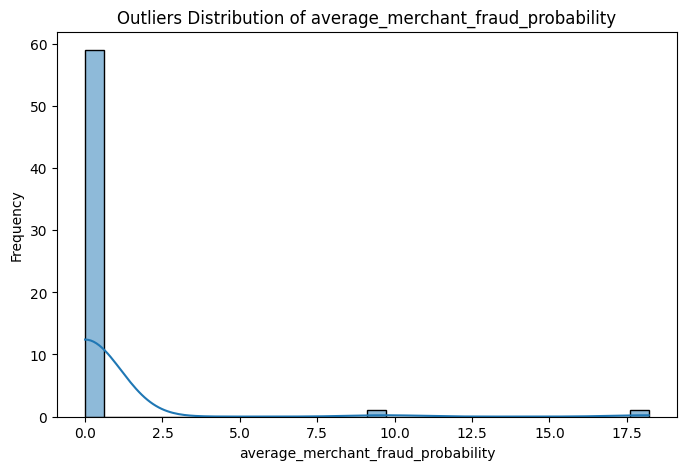

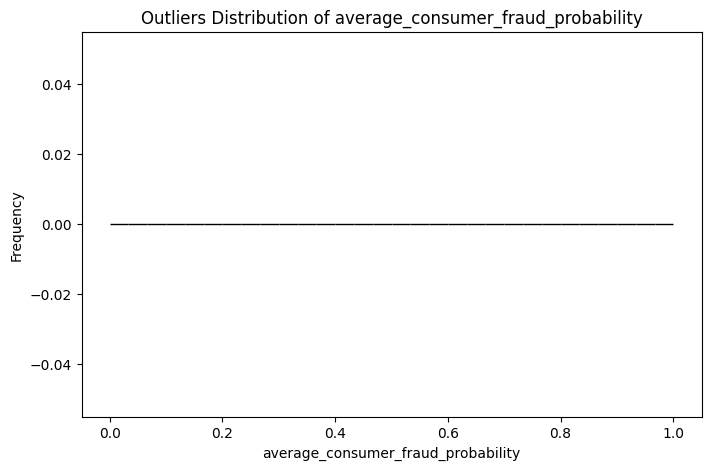

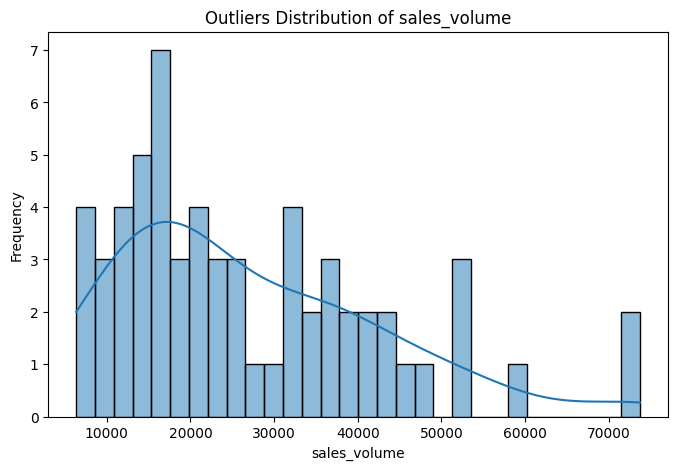

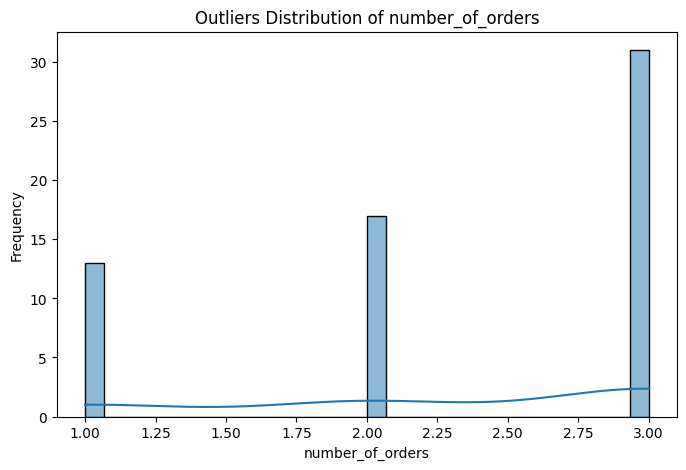

In [6]:
columns_to_plot = ['average_merchant_fraud_probability', 'average_consumer_fraud_probability', 'sales_volume']

for col in columns_to_plot + ['number_of_orders']:
    plt.figure(figsize=(8,5))
    sns.histplot(outliers_df[col], kde=True, bins=30)  # you can adjust the number of bins as needed
    plt.title(f'Outliers Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [7]:
df_pandas_cleaned = df_pandas.loc[df_pandas['number_of_orders'] > 3]


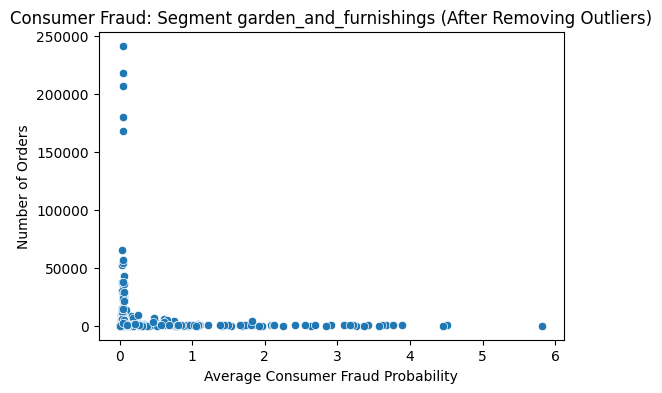

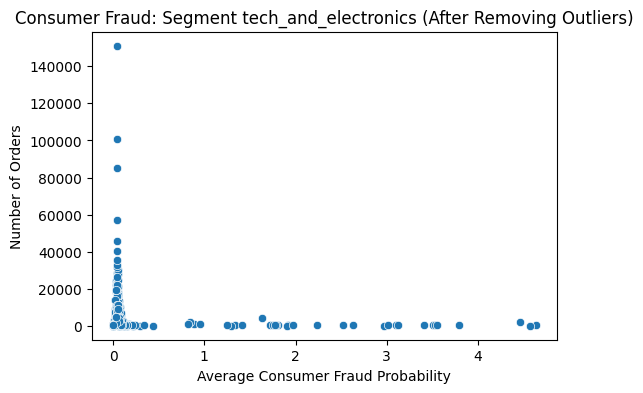

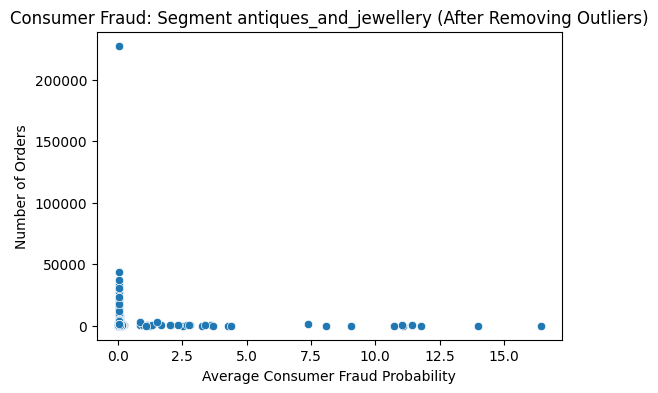

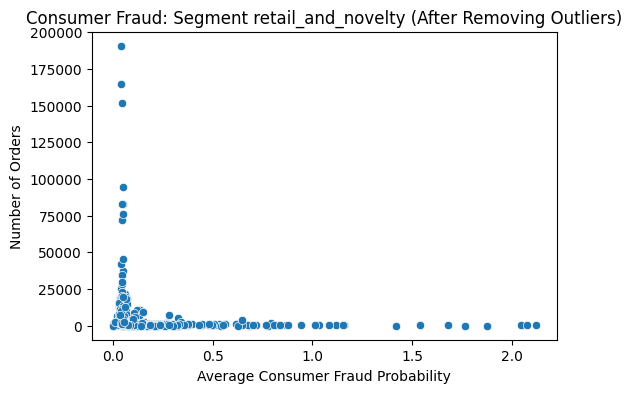

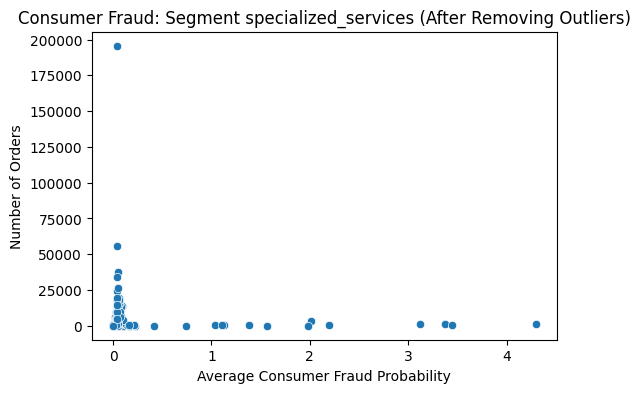

In [8]:
# Loop through each segment and plot
for segment in df_pandas_cleaned['segment'].unique():
    segment_df = df_pandas_cleaned[df_pandas_cleaned['segment'] == segment]

    # Filter the cleaned dataframe for each segment    
    # Plotting the scatter plot for merchant fraud
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Consumer Fraud: Segment {segment} (After Removing Outliers)')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


Summary Statistics for average_consumer_fraud_probability:

count    2570.000000
mean        0.233920
std         0.883834
min         0.000000
25%         0.033805
50%         0.050964
75%         0.087058
max        16.428210
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



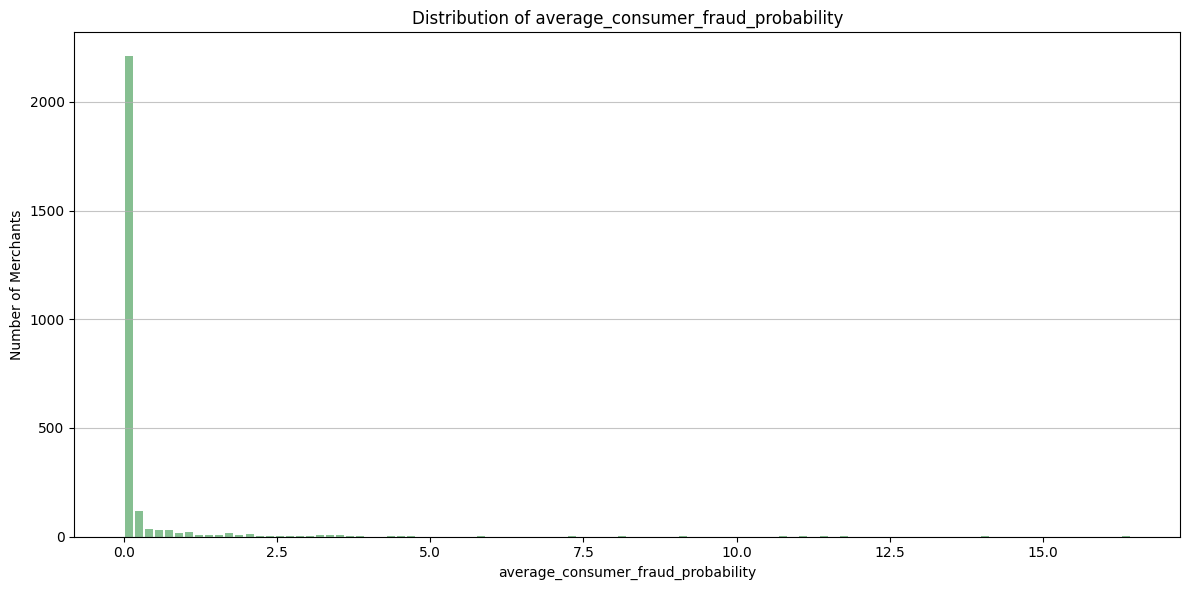

Summary Statistics for avg_median_age:

count    3965.000000
mean       43.111765
std         0.778923
min        36.800000
25%        42.917910
50%        43.107091
75%        43.297030
max        50.500000
Name: avg_median_age, dtype: float64

--------------------------------------------------



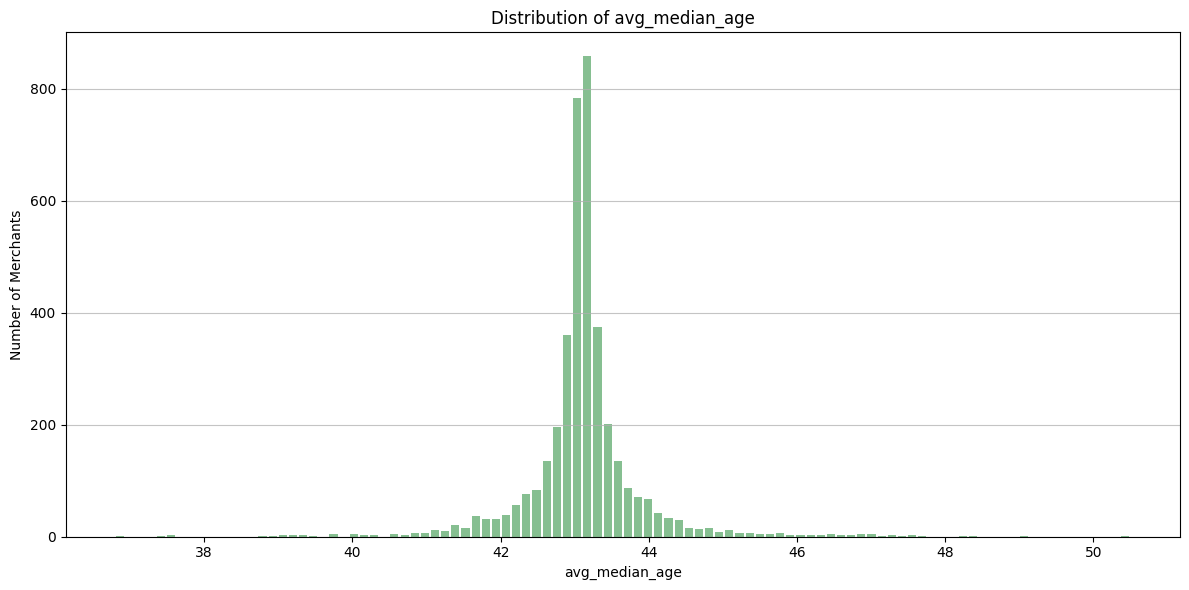

Summary Statistics for avg_total_weekly_personal_income:

count    3965.000000
mean      789.913466
std        25.799114
min       607.000000
25%       783.161473
50%       790.173236
75%       796.571918
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



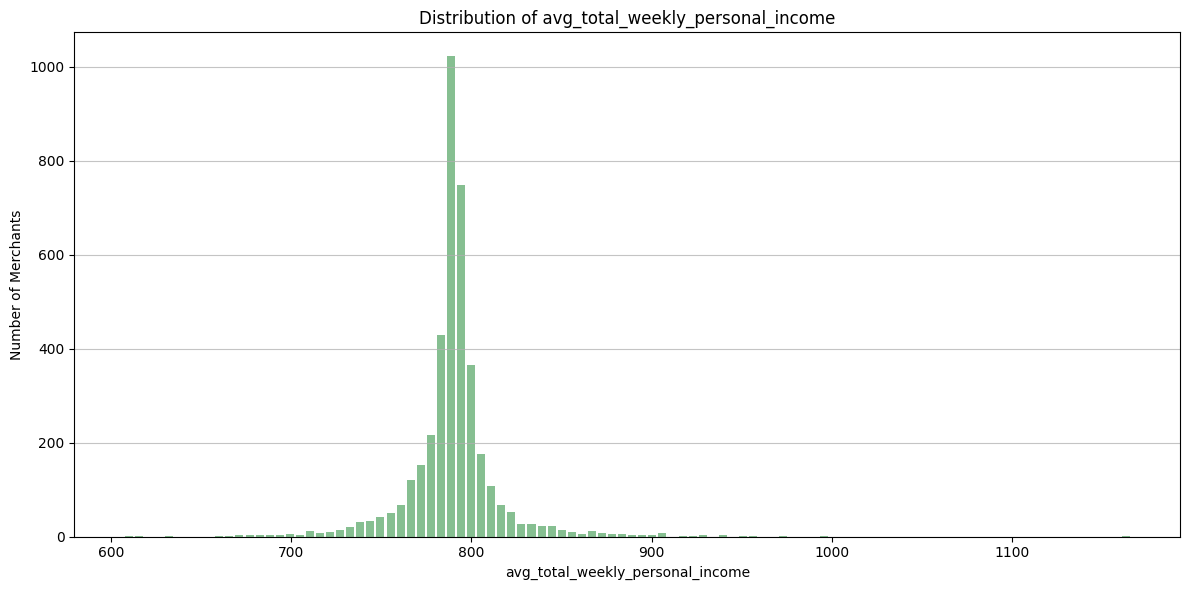

Summary Statistics for take_rate:

count    3965.000000
mean        4.404149
std         1.783473
min         0.100000
25%         2.980000
50%         4.510000
75%         6.040000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



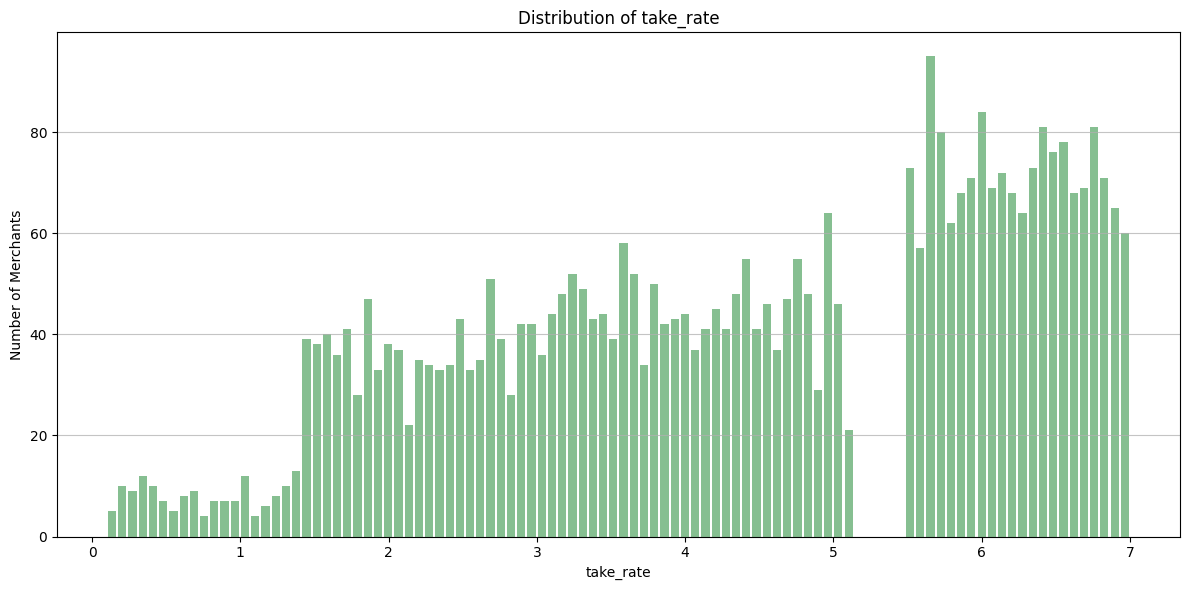

Summary Statistics for average_cost_of_order:

count     3965.000000
mean       966.292080
std       2205.253355
min          7.579072
25%        117.174316
50%        308.998835
75%        766.193804
max      28754.635213
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



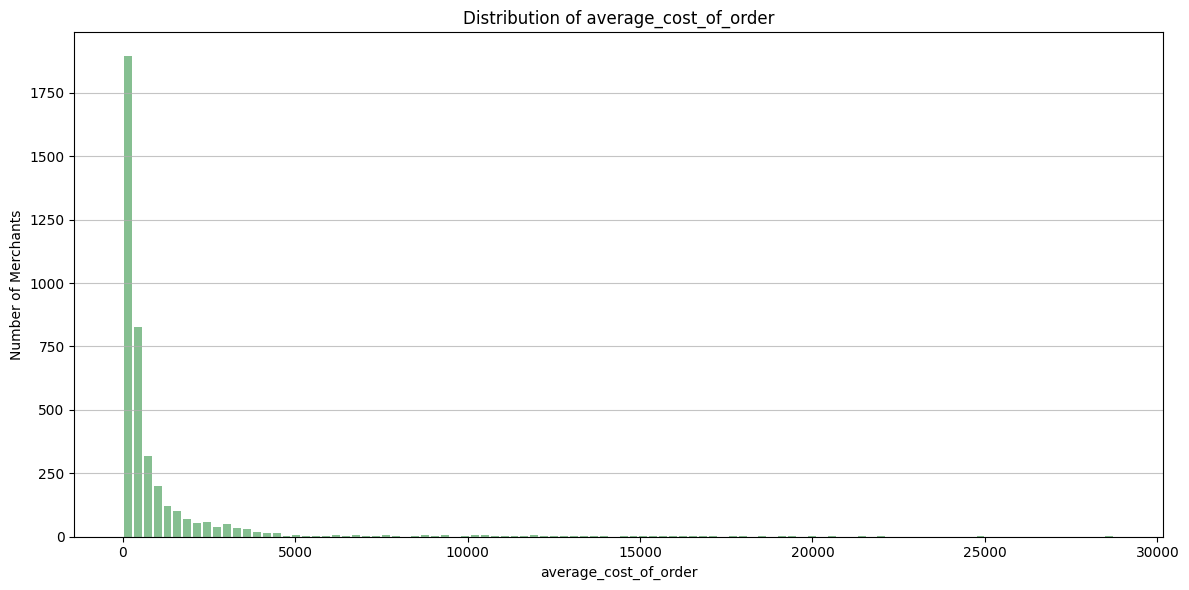

Summary Statistics for number_of_orders:

count      3965.000000
mean       2868.248424
std       11902.000660
min           4.000000
25%          84.000000
50%         363.000000
75%        1751.000000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



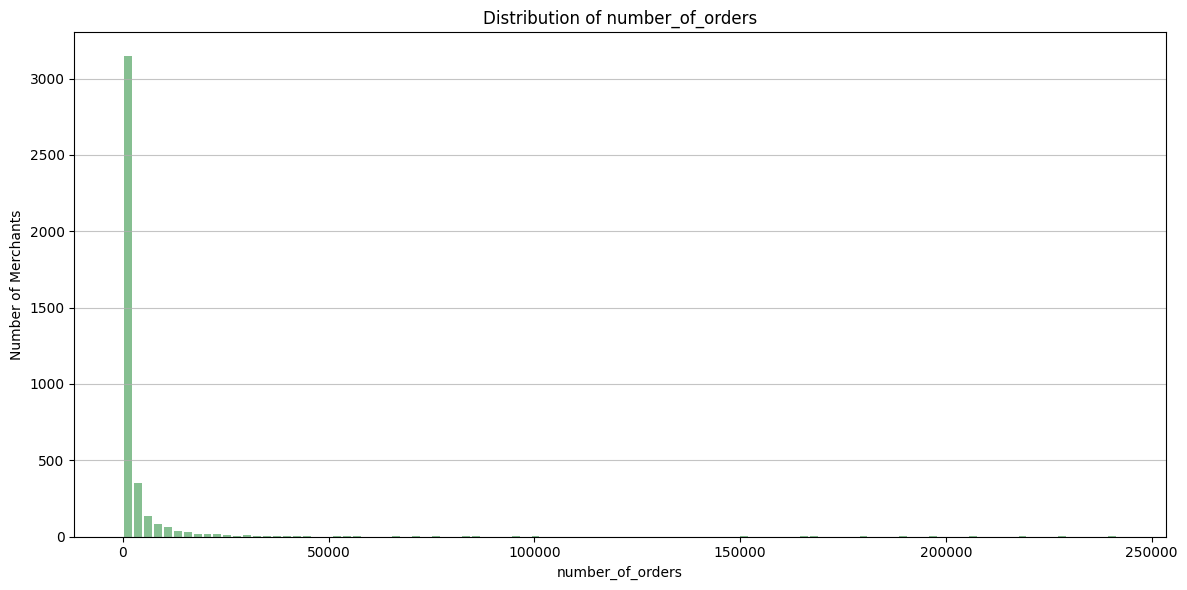

KeyError: 'number_of_consumers'

In [9]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_unique_of_consumers",
    "average_merchant_fraud_probability",
    "average_consumer_fraud_probability", 
]

df_pandas = df_pandas_cleaned
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

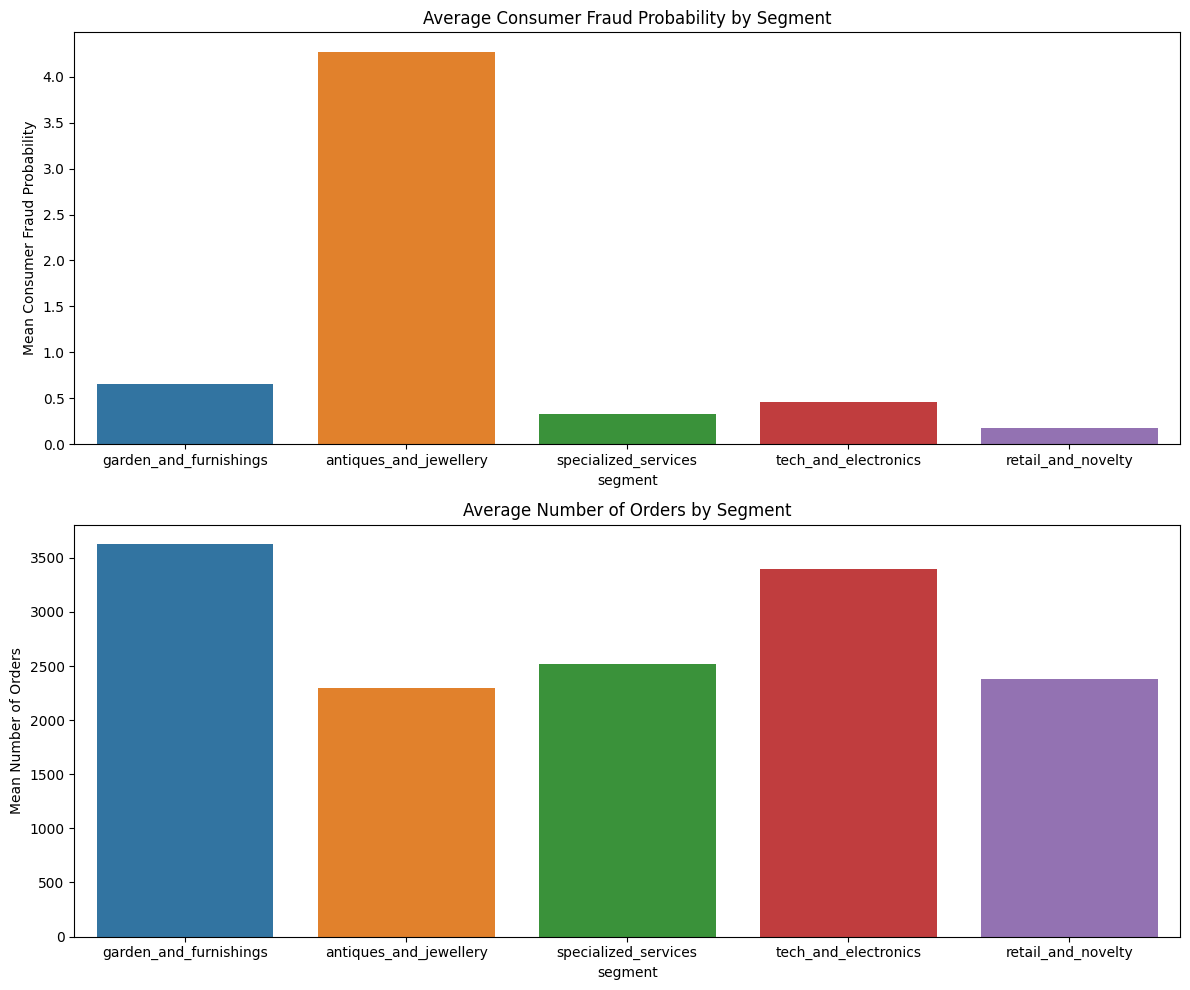

In [ ]:
df = spark.createDataFrame(df_pandas_cleaned)
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()

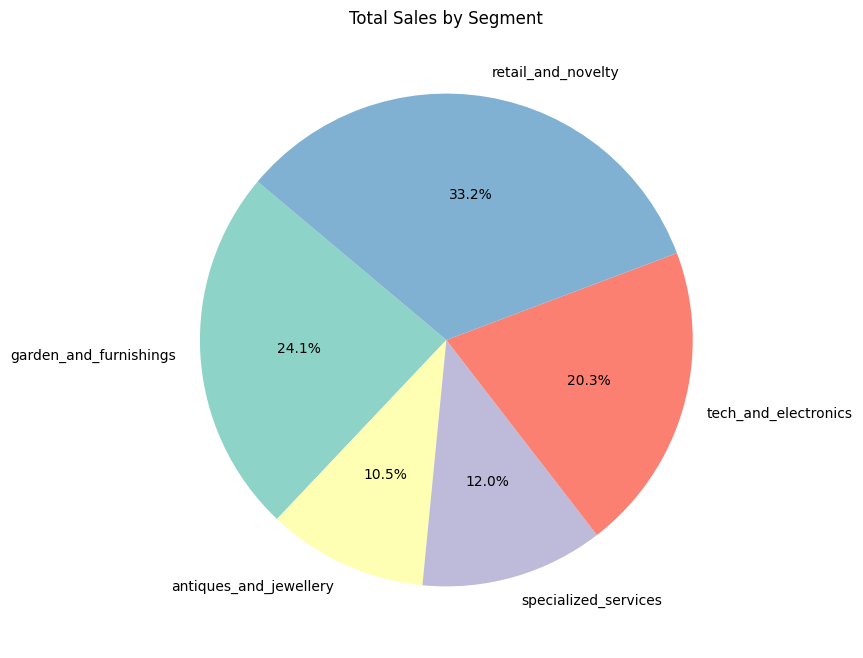

In [ ]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()

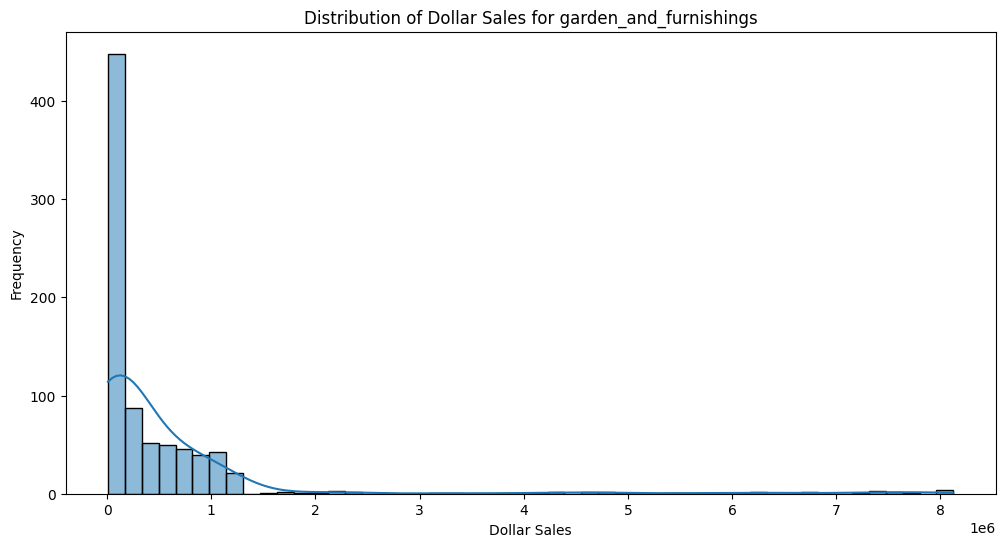

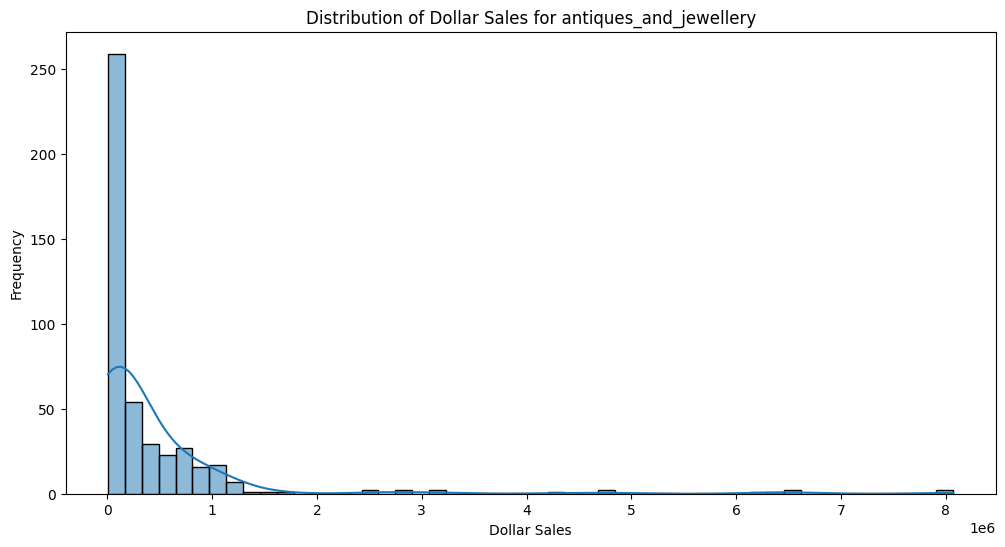

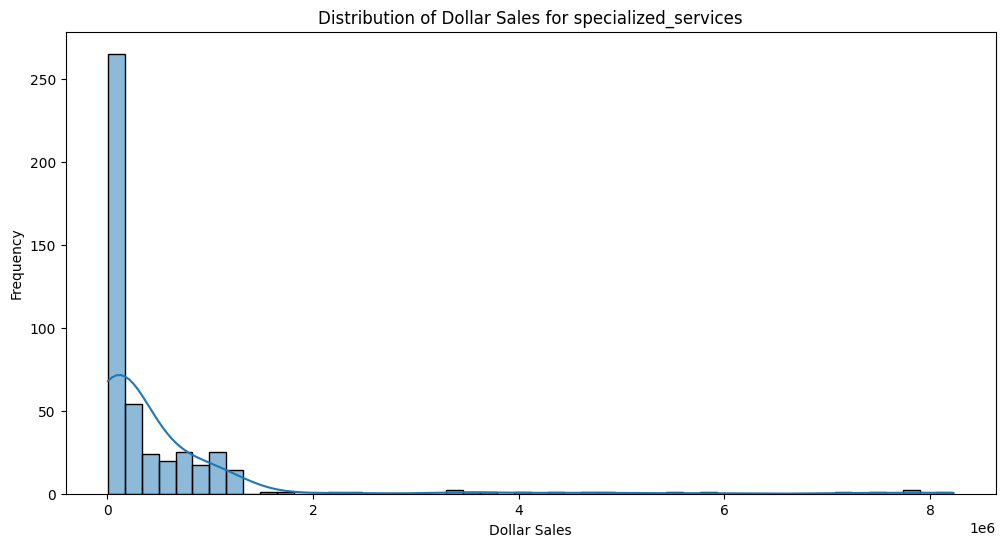

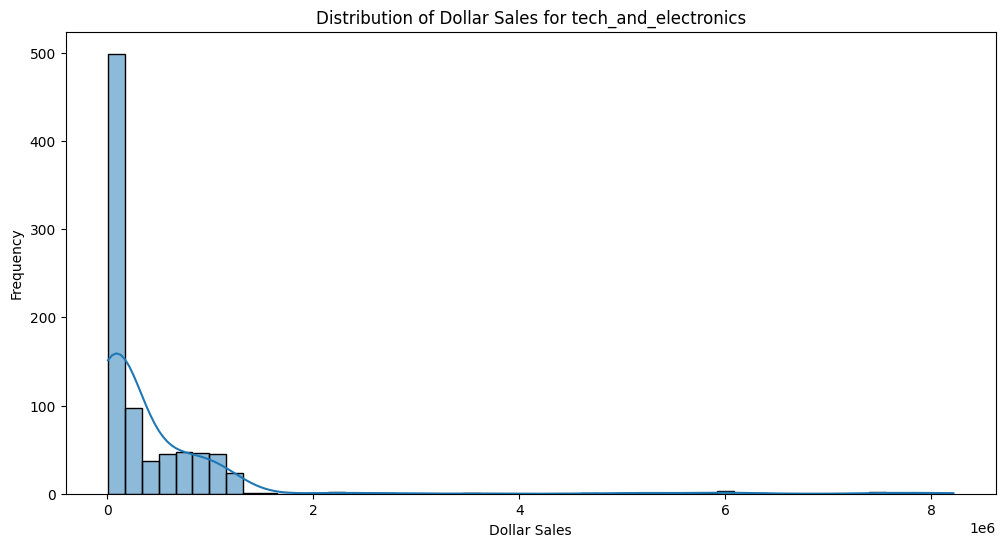

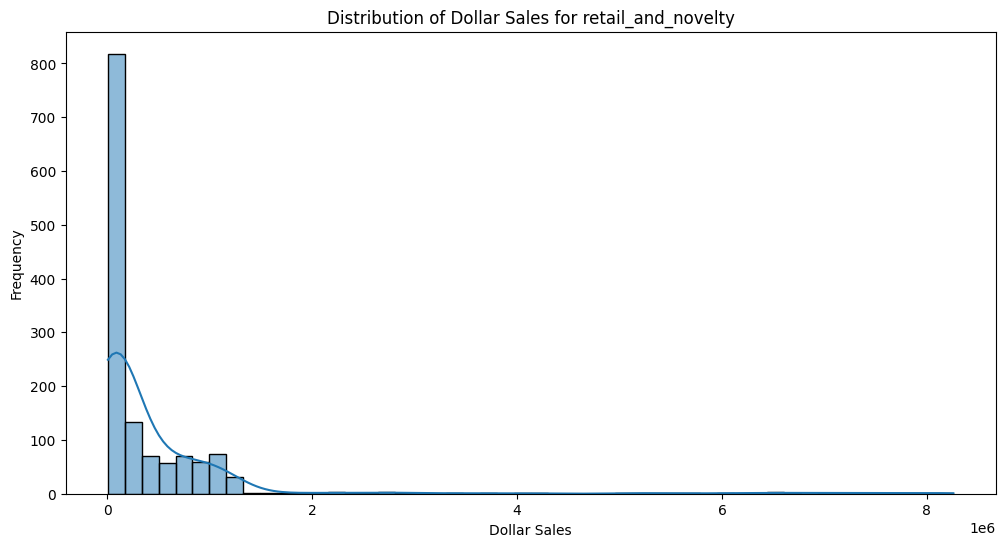

In [ ]:
segments = df.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in segments:
    segment_df = df.filter(df.segment == segment)
    
    # Check if the segment dataframe is not empty
    if segment_df.count() > 0:
        segment_df = segment_df.withColumn("dollar_sales", segment_df["average_cost_of_order"] * segment_df["number_of_orders"])
        plt.figure(figsize=(12, 6))
        segment_df_pandas = segment_df.toPandas()
        sns.histplot(segment_df_pandas['dollar_sales'], kde=True, bins=50)
        plt.title(f'Distribution of Dollar Sales for {segment}')
        plt.xlabel('Dollar Sales')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print(f"No data for segment: {segment}")

In [ ]:
df.write.mode('overwrite').parquet("../../../data/curated/removed_outliers.parquet")
